# Setup

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans, AgglomerativeClustering
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
from collections import Counter
from pprint import pprint
import matplotlib.colors as mcolors
import matplotlib.collections as mcollections
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

In [19]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
prices_df.index = pd.to_datetime(prices_df.index)
caps_df = pd.read_csv(cap_path, index_col='date')
caps_df.index = pd.to_datetime(caps_df.index)

In [20]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print('Original Length')
print(f'Price data: {num_rows}')
num_rows = len(caps_df)
print(f'Price data: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
test_prices_df = prices_df[np.round(num_rows/2).astype(int):]
test_caps_df = caps_df[np.round(num_rows/2).astype(int):]
caps_df = caps_df[:np.round(num_rows/2).astype(int)]
print('Price Data')
num_rows = len(train_df)
print(f'Train Length: {num_rows}')
num_rows = len(test_prices_df)
print(f'Test Length: {num_rows}')
print('Cap Data')
num_rows = len(caps_df)
print(f'Train Length: {num_rows}')
num_rows = len(test_caps_df)
print(f'Test Length: {num_rows}')

Original Length
Price data: 5787
Price data: 5787
Price Data
Train Length: 2894
Test Length: 2893
Cap Data
Train Length: 2894
Test Length: 2893


In [21]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10810
2467


# Sectors

In [22]:
Market_dict = {}
file_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/Nasdaq_sectors.csv'
nasdaq_sectors = pd.read_csv(file_path)
cols_to_keep = ['Symbol', 'Sector']
nasdaq_sectors = nasdaq_sectors[cols_to_keep]

In [23]:
for Sector in nasdaq_sectors['Sector'].unique().tolist():
    if pd.notna(Sector):
        Market_dict[Sector] = []
        temp_df = nasdaq_sectors[nasdaq_sectors['Sector']==Sector]
        for stk in temp_df['Symbol'].unique().tolist():
            if stk in complete_stock_list:
                Market_dict[Sector].append(stk)

In [24]:
for Sector in list(Market_dict.keys()):
    print(Sector)
    print(len(Market_dict[Sector]))

Industrials
343
Finance
430
Real Estate
101
Health Care
679
Consumer Discretionary
630
Technology
414
Basic Materials
19
Consumer Staples
75
Energy
100
Miscellaneous
24
Utilities
73
Telecommunications
35


In [25]:
full_market_dict = Market_dict

# Functions

### Clustering

In [26]:
def get_corr_matrix(DataFrame):
    #print()
    return DataFrame.corr()

In [27]:
def K_mean_clustering(DataFrame, num_clusters, n_init):
    if (DataFrame.isnull().values.any()):
        print('Warning: Null/NaN values found in clustering data')
    X = get_corr_matrix(DataFrame)
    if X.isnull().values.any():
        print('Warning: Null/NaN values found in correlation data')
    #X = ((1-X)/2.)**.5 #distance matrix
    kmeans = KMeans(n_clusters=num_clusters, n_init=n_init).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name] 
    return cluster_dict

In [28]:
def spectral_clustering(df, num_clusters):
    A = abs(df.corr().values)
    #A = df.corr().values
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [29]:
def Hierarchical_clustering(df, num_clusters):
    X = get_corr_matrix(df)
    X = ((1-X)/2.)**.5 #distance matrix
    HC_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')
    labels = HC_clustering.fit(X).labels_
    stocks = X.columns.tolist()
    cluster_dict = {}
    for i in range(len(labels)):
        cluster = labels[i]
        member = stocks[i]
        if cluster not in cluster_dict.keys():
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(member)
    return cluster_dict

### Trading

In [30]:
def trading(
        prices_dataframe, caps_dataframe, market_dictionary, 
        available_sector_list, num_clusters, num_sectors, n_market_cap, n_cv, 
        consider_cv, cluster, cluster_method, final_beta_validation,
        run_frequency, n_runs, n_initializations, record_clustering, record_stock_selection):
    #### Setup
    all_dates_list = prices_dataframe.index.tolist() # full list of all dates
    trading_results_dict = {} # records trades
    stocks_currently_in_trade = []
    if record_clustering == 'Yes':
        clustering_output_data = []
    if record_stock_selection == 'Yes':
        Stocks_considered_record = {} # records the stock selection

    ### Find the available dates/periods
    dates_dictionary = {}
    period_counter = 0
    current_first_day = ''
    for i in range(len(all_dates_list)):
        if (i+1) < len(all_dates_list):
            current_day = all_dates_list[i]
            next_day = all_dates_list[(i+1)]
            if i == 0:
                current_first_day = current_day
            if run_frequency == 'Monthly':
                current_day_month = current_day.month
                next_day_month = next_day.month
                if current_day_month != next_day_month:
                    #print(current_first_day, current_day)
                    dates_dictionary[period_counter] = (current_first_day, current_day)
                    current_first_day = next_day
                    period_counter += 1
            elif run_frequency == 'Weekly':
                current_day_week = current_day.isocalendar().week
                next_day_week = next_day.isocalendar().week
                if next_day_week != current_day_week:
                    #print(current_first_day, current_day)
                    if current_first_day != current_day:
                        dates_dictionary[period_counter] = (current_first_day, current_day)
                        current_first_day = next_day
                        period_counter += 1
                    else:
                        current_first_day = next_day
            else:
                print('Error: Invalid run_frequency entered, please choose ("Monthly"/"Weekly")')
                return 0
    #print(dates_dictionary)
    ### decide how long to run
    total_runs = 0
    if n_runs == 'Max':
        total_runs = len(dates_dictionary)
    else:
        total_runs = int(n_runs)
    
    #### Main function
    for i in range(total_runs):
        first_day_of_period, last_day_of_period = dates_dictionary[i]

        ### Trading pt1: close existing trades
        #print('...closing_trades...')
        #print(f'Stocks currently in trade: {stocks_currently_in_trade}')
        if len(stocks_currently_in_trade) > 0: # are there any?
            for trading_stock in stocks_currently_in_trade: # iterate over the list
                # close the trade
                open_price = trading_results_dict[trading_stock]['Open_price'][-1]
                close_price = prices_dataframe.loc[last_day_of_period, trading_stock]
                if pd.isna(close_price): # iterate backward
                    index_position = all_dates_list.index(last_day_of_period) # Find the current index in index_dict
                    while pd.isna(close_price) and index_position > 0:
                        index_position -= 1
                        close_price = prices_dataframe.loc[all_dates_list[index_position], trading_stock]
                trading_results_dict[trading_stock]['Close_date'].append(last_day_of_period)
                trading_results_dict[trading_stock]['Close_price'].append(close_price)
                if trading_results_dict[trading_stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trading_results_dict[trading_stock]['Profit'].append(profit)
                #print(trading_stock)
        stocks_currently_in_trade = []

        ### Stock & Sector Selection
        new_stocks_considered_row = {}
        sectors_to_consider = []
        if num_sectors == len(available_sector_list):
            sectors_to_consider = available_sector_list
        else:
            #print('starting loop')
            sector_cap_dictionary = {}
            for sctr in available_sector_list:
                #print(sctr)
                sctr_stocks = market_dictionary[sctr]
                #print(len(sctr_stocks))
                #print(first_day_of_period, last_day_of_period)
                sector_df = caps_dataframe[sctr_stocks][first_day_of_period:last_day_of_period]
                #print(len(sector_df.columns.tolist()))
                #print(len(sector_df))
                sector_df = sector_df.dropna(axis=1)
                #print(len(sector_df.columns.tolist()))
                #print(len(sector_df))
                mean_cap = sector_df.values.mean()
                sector_cap_dictionary[sctr] = mean_cap
            ranked_sectors = sorted(sector_cap_dictionary.items(), key=lambda item: item[1], reverse=True)
            ranked_sectors = ranked_sectors[:num_sectors]
            for s_tpl in ranked_sectors:
                sectors_to_consider.append(s_tpl[0])
            #print('ending loop')
            #print()

        if len(sectors_to_consider) != num_sectors:
            print('Warning: Not enough sectors found')
            print('--------------------------------')
            print(sectors_to_consider)
        if pd.Series(sectors_to_consider).nunique() != num_sectors:
            print('Warning: Duplicate sectors found')
            print('--------------------------------')
            print(sectors_to_consider)

        stocks_to_consider = []
        price_data = prices_dataframe[first_day_of_period:last_day_of_period]
        caps_data = caps_dataframe[first_day_of_period:last_day_of_period]
        for sector in sectors_to_consider:
            new_stocks_considered_row[sector] = []
            sector_stocks_unchecked = market_dictionary[sector]
            sector_stocks_non_null = []
            sector_stocks = []
            for stoc in sector_stocks_unchecked:
                if price_data[stoc].isna().any() != True:
                    sector_stocks_non_null.append(stoc)
            if len(sector_stocks_non_null) < n_market_cap:
                print(f'Warning: Less than {n_market_cap} non-null stocks found')
                print('-----------------------------------------------------------')
                print(f'sector: {sector}')
                print(f'stocks non-null: {sector_stocks_non_null}')  
            for stoc in sector_stocks_non_null:
                if price_data[stoc].nunique() != 1:
                    sector_stocks.append(stoc)
            if len(sector_stocks) < n_market_cap:
                print(f'Warning: Less than {n_market_cap} non-const stocks found')
                print('-----------------------------------------------------------')
                print(f'sector: {sector}')
                print(f'stocks non-const: {sector_stocks}')
                print(price_data[sector_stocks_non_null])  
            top_cap_stocks = list(caps_data[sector_stocks].mean().nlargest(n_market_cap).index)
            if consider_cv == 'Yes':
                stocks_cv_dict = {}
                for stk in top_cap_stocks:
                    std_dev = float(np.std(price_data[stk]))
                    mean = float(np.mean(price_data[stk]))
                    cv = std_dev/mean
                    stocks_cv_dict[stk] = cv
                least_varied = sorted(stocks_cv_dict.items(), key=lambda x:x[1])[:n_cv]
                for stk_tpl in least_varied:
                    stk_name = stk_tpl[0]
                    stocks_to_consider.append(stk_name)
                    new_stocks_considered_row[sector].append(stk_name)
            else:
                for stk in top_cap_stocks:
                    stocks_to_consider.append(stk)
                    new_stocks_considered_row[sector].append(stk)
        Stocks_considered_record[first_day_of_period] = new_stocks_considered_row

        ### Clustering 
        possible_missclassified_stocks = []
        if cluster == 'Yes':
            if cluster_method == 'KMeans':
                cluster_entry = K_mean_clustering(price_data[stocks_to_consider], num_clusters, n_init=n_initializations)
            elif cluster_method == 'Spectral':
                cluster_entry = spectral_clustering(price_data[stocks_to_consider], num_clusters)
            elif cluster_method == 'Hierarchial':
                cluster_entry = Hierarchical_clustering(price_data[stocks_to_consider], num_clusters)
            for cluster_name in list(cluster_entry.keys()): # iterate over the n clusters
                # pull the members and sort the sectors
                cluster_members = cluster_entry[cluster_name]
                #new_clustering_row[f'Cluster_{int(cluster_name)+1}_Members'] = cluster_members
                cluster_members_dict = {}
                cluster_sectors = []
                for stk in cluster_members:
                    for sctr in market_dictionary:
                        stocks_list = market_dictionary[sctr]
                        if stk in stocks_list:
                            if sctr not in cluster_sectors:
                                cluster_sectors.append(sctr)
                for sctr in cluster_sectors:
                    cluster_members_dict[sctr] = []
                for stk in cluster_members:
                    for sctr in market_dictionary:
                        stocks_list = market_dictionary[sctr]
                        if stk in stocks_list:
                            cluster_members_dict[sctr].append(stk)
                # identify misclassified stocks
                if len(cluster_sectors) > 1:
                    sctr_lengths = np.array([len(value_list) for value_list in cluster_members_dict.values()])
                    even_split = np.all(sctr_lengths == sctr_lengths[0])
                    if even_split == False:
                        cluster_members_cnt_dict = {}
                        for sctr in cluster_members_dict:
                            cluster_members_cnt_dict[sctr] = len(cluster_members_dict[sctr])
                        highest_num_stks = max(cluster_members_cnt_dict.values())
                        lowest_num_stks = min(cluster_members_cnt_dict.values())
                        has_majority = list(cluster_members_cnt_dict.values()).count(highest_num_stks) == 1
                        has_minority = list(cluster_members_cnt_dict.values()).count(lowest_num_stks) == 1
                        if has_majority:
                            if has_minority:
                                minority_sctr = [sctr for sctr, count in cluster_members_cnt_dict.items() if count == lowest_num_stks][0]
                                minority_stks = cluster_members_dict[minority_sctr]  
                                if len(minority_stks) == 1:
                                    possible_missclassified_stocks.append(minority_stks[0]) 

        ### Trading pt2: new trades
        #print('...opening_trades...')
        stocks_to_trade = []
        if cluster == 'Yes':
            for minority_stk in possible_missclassified_stocks:
                if final_beta_validation == 'Yes':
                    # find the minority stocks sector
                    minority_sctr = ''
                    for sctr in market_dictionary:
                        sctrs_stocks = market_dictionary[sctr]
                        if minority_stk in sctrs_stocks:
                            minority_sctr = sctr
                            break
                    # view its peers and view their behavior, trade or not accordingly 
                    minority_sctr_stks = market_dictionary[minority_sctr]
                    peer_stocks = []
                    for possible_peer_stock in stocks_to_consider:
                        if possible_peer_stock in minority_sctr_stks:
                            peer_stocks.append(possible_peer_stock)
                    peer_stocks.remove(minority_stk)
                    up_cntr = 0
                    down_cntr = 0
                    for peer_stk in peer_stocks:
                        stk_price_data = price_data[peer_stk]
                        covariance = np.cov(range(len(stk_price_data)), stk_price_data.values)
                        beta = covariance[0,1]
                        if beta > 0:
                            up_cntr +=1
                        else:
                            down_cntr +=1
                    if (up_cntr == 0) or (down_cntr == 0):
                        if up_cntr > 0: # peers are going up
                            # check if the minority is going down
                            minority_stk_price_data = price_data[minority_stk]
                            covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                            beta = covariance[0,1]
                            if beta < 0:
                                stocks_to_trade.append((minority_stk, 'Long'))
                        elif down_cntr > 0: # peers are going down
                            # check if the minority is going up
                            minority_stk_price_data = price_data[minority_stk]
                            covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                            beta = covariance[0,1]
                            if beta < 0:
                                stocks_to_trade.append((minority_stk, 'Short'))
                else:
                    minority_stk_price_data = price_data[minority_stk]
                    covariance = np.cov(range(len(minority_stk_price_data)), minority_stk_price_data.values)
                    beta = covariance[0,1]
                    if beta > 0: # short
                        stocks_to_trade.append((minority_stk, 'Short'))
                    else: # long
                        stocks_to_trade.append((minority_stk, 'Long'))
        else: # we didn't use clustering
            for sctr in list(new_stocks_considered_row.keys()):
                sctrs_stocks = new_stocks_considered_row[sctr]
                for stk in sctrs_stocks:
                    stk_price_data = price_data[stk]
                    covariance = np.cov(range(len(stk_price_data)), stk_price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        stocks_to_trade.append((stk, 'Short'))
                    else:
                        stocks_to_trade.append((stk, 'Long'))
        #print(f'Stocks to trade: {stocks_to_trade}')
        #print(len(stocks_to_trade))
        if len(stocks_to_trade) > 0:
            for trading_stock_tpl in stocks_to_trade:
                stk_name = trading_stock_tpl[0]
                trading_direction = trading_stock_tpl[1]
                current_price = price_data.loc[last_day_of_period, stk_name]
                if stk_name in list(trading_results_dict.keys()):
                    trading_results_dict[stk_name]['Open_date'].append(last_day_of_period)
                    trading_results_dict[stk_name]['Trade_type'].append(trading_direction)
                    trading_results_dict[stk_name]['Open_price'].append(current_price)
                else: 
                    trading_results_dict[stk_name] = {
                        'Open_date':[last_day_of_period],
                        'Close_date':[],
                        'Trade_type':[trading_direction],
                        'Open_price':[current_price],
                        'Close_price':[],
                        'Profit':[],
                        }
                #print(stk_name)
                stocks_currently_in_trade.append(stk_name)   
                
    return trading_results_dict

In [31]:
sector_list = ['Industrials',
    'Finance',
    'Real Estate',
    'Health Care', 
    'Consumer Discretionary',
    'Technology',
    'Basic Materials',
    'Consumer Staples',
    'Energy',
    'Utilities',
    'Telecommunications'
]

### Analysis

In [32]:
def cum_sum_plot_single(trading_results):
    # Get all the possible timestamps
    all_timestamps = sorted(set(ts for stock in trading_results for ts in trading_results[stock]['Close_date']))
    temp_data = {
        'Time': all_timestamps,
        'Cumulative_Sum': []
    }
    cum_sum = 0
    for timestamp in all_timestamps:
        # Find profits for this timestamp
        profits = []
        for stock in trading_results:
            for index_pos, ts in enumerate(trading_results[stock]['Close_date']):
                if ts == timestamp:
                    profits.append(trading_results[stock]['Profit'][index_pos])
        # Ensure cumulative sum is increasing correctly
        cum_sum += np.sum(profits)
        temp_data['Cumulative_Sum'].append(cum_sum)
    return pd.DataFrame(temp_data).set_index('Time')

In [33]:
def cum_sum_plot_multiple(*trading_results):
    plt.figure(figsize=(10, 5))
    for i, results in enumerate(trading_results):
        all_timestamps = sorted(set(ts for stock in results for ts in results[stock]['Close_date']))    
        temp_data = {
            'Time': all_timestamps,
            'Cumulative_Sum': []
        }
        cum_sum = 0
        for timestamp in all_timestamps:
            profits = []
            for stock in results:
                for index_pos, ts in enumerate(results[stock]['Close_date']):
                    if ts == timestamp:
                        profits.append(results[stock]['Profit'][index_pos])
            
            cum_sum += np.sum(profits)
            temp_data['Cumulative_Sum'].append(cum_sum)

        df = pd.DataFrame(temp_data).set_index('Time')
        # Plot each dataset with a unique label
        plt.plot(df.index, df['Cumulative_Sum'], label=f'Num Sectors: {i+2}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Sum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Testing

### Functions

In [34]:
def run_trading_KMeans_1(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='KMeans', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'KMeans Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [35]:
def run_trading_Spectral(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='Spectral', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Spectral Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [36]:
def run_trading_Hierarchial(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='Hierarchial', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Hierarchial Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [37]:
def run_trading_noCluster(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 1
    for i in range(n_iterations):
        #print(f'Iteration: {i}')
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=1, consider_cv='Yes', cluster='No', 
            cluster_method='KMeans', final_beta_validation='Yes', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'No Clustering Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

## Train

### Kmeans

In [38]:
#run_trading_KMeans_1('Monthly', 'Max', train_df, caps_df)

In [39]:
#run_trading_KMeans_1('Weekly', 'Max', train_df, caps_df)

### No clustering

In [40]:
# new baseline for non-clustering

# buy and hold method:
# 7 sectors
# from each sector, begining of the month, buy the top market cap stocks
# hold it until the end of the month then sell
# top ten market cap, lowest cv, should be 1 stock 

In [41]:
#run_trading_noCluster('Monthly', 'Max', train_df, caps_df)

### Hierarchial

In [42]:
import warnings
# Suppress the specific scipy warning about the distance matrix
warnings.filterwarnings(
    "ignore",
    message=".*The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix.*",
    category=UserWarning,
    module="sklearn.cluster._agglomerative"
)

In [43]:
#run_trading_Hierarchial('Monthly', 'Max', train_df, caps_df)

In [44]:
#run_trading_Hierarchial('Weekly', 'Max', train_df, caps_df)

### Testing KMeans Stabilization/Initialization

In [45]:
def run_trading_testing_KMeans(Inits_list, run_frequency, n_runs):
    init_results_dict = {}
    for init in Inits_list:
        temp_results_dict = {}
        for i in range(3):
            trading_res = trading(prices_dataframe=train_df, caps_dataframe=caps_df, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='KMeans', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=int(init), record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
            cum_sum_series = cum_sum_plot_single(trading_res)
            temp_results_dict[f'Run_{i}'] = cum_sum_series
        temp_df = pd.concat(temp_results_dict, axis=1)
        temp_df.ffill(inplace=True)
        avg_profit_curve = temp_df.mean(axis=1)
        init_results_dict[f'{init}_initializations'] = avg_profit_curve
    init_results_df = pd.concat(init_results_dict, axis=1)
    init_results_df.ffill(inplace=True)
    init_results_df.plot()


In [46]:
#Inits_list = ['10','100','1000','10000']
#run_trading_testing_KMeans(Inits_list, 'Monthly', 'Max')

## Test

In [47]:
# monthly hierarchial with testing data
#run_trading_Hierarchial('Monthly', 'Max', test_prices_df, test_caps_df)

# Train & Test (may onward)

### imports, setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans, AgglomerativeClustering
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
from collections import Counter
from pprint import pprint
import matplotlib.colors as mcolors
import matplotlib.collections as mcollections
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

In [49]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
prices_df.index = pd.to_datetime(prices_df.index)
caps_df = pd.read_csv(cap_path, index_col='date')
caps_df.index = pd.to_datetime(caps_df.index)

In [50]:
halfway_pos = len(prices_df) // 2
halfway_index_label = prices_df.index[halfway_pos]
print(halfway_index_label)

2011-07-05 00:00:00


### Functions

In [54]:
def run_trading_KMeans_1(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='KMeans', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'KMeans Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [55]:
def run_trading_Spectral(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='Spectral', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Spectral Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    plt.ylabel("Cumlative Sum")
    plt.show()

In [66]:
def run_trading_Hierarchial(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 5
    for i in range(n_iterations):
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='Hierarchial', final_beta_validation='No', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'Hierarchial Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    date_str = "2011-07-05 00:00:00"
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='grey', linestyle='--', label='Event')
    plt.ylabel("Cumlative Sum")
    plt.show()

In [67]:
def run_trading_noCluster(run_frequency, n_runs, prices_data, caps_data):
    trading_results_dict = {}
    n_iterations = 1
    for i in range(n_iterations):
        #print(f'Iteration: {i}')
        trading_res = trading(prices_dataframe=prices_data, caps_dataframe=caps_data, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=1, consider_cv='Yes', cluster='No', 
            cluster_method='KMeans', final_beta_validation='Yes', run_frequency=run_frequency, 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs=n_runs)
        cum_sum_series = cum_sum_plot_single(trading_res)
        trading_results_dict[f'Run_{i}'] = cum_sum_series
    temp_df = pd.concat(trading_results_dict, axis=1)
    temp_df.plot(title=f'No Clustering Cumlative Sums({n_iterations} Iterations)', legend=False)
    plt.xlabel("Date")
    date_str = "2011-07-05 00:00:00"
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='grey', linestyle='--', label='Event')
    plt.ylabel("Cumlative Sum")
    plt.show()

In [58]:
#date_str = "2011-07-05 00:00:00"
#date = pd.to_datetime(date_str)
#plt.axvline(x=date, color='red', linestyle='--', label='Event')

### running

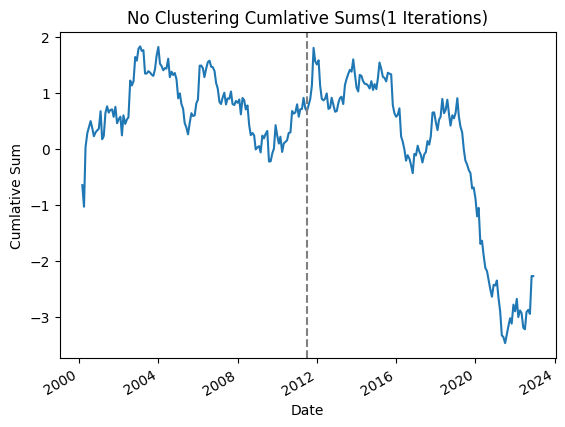

In [68]:
run_trading_noCluster('Monthly', 'Max', prices_df, caps_df)

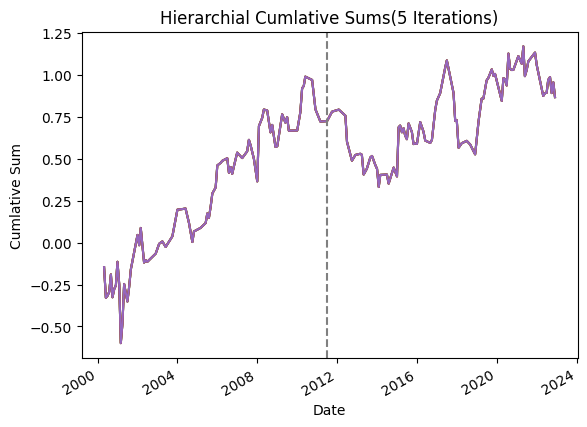

In [69]:
run_trading_Hierarchial('Monthly', 'Max', prices_df, caps_df)

In [125]:
trading_res = trading(prices_dataframe=prices_df, caps_dataframe=caps_df, market_dictionary=full_market_dict,
            available_sector_list=sector_list, num_clusters=7, num_sectors=7,
            n_market_cap=10, n_cv=4, consider_cv='Yes', cluster='Yes', 
            cluster_method='Hierarchial', final_beta_validation='No', run_frequency='Monthly', 
            n_initializations=20, record_clustering='Yes', record_stock_selection='Yes', n_runs='Max')

In [127]:
def inspect_trade_results(trading_res):
    # Build DataFrame from safe lengths (based on Open_date)
    rows = []
    for ticker, trades in trading_res.items():
        n = len(trades['Open_date'])
        for i in range(n):
            row = {
            'Ticker': ticker,
            'Open_date': trades['Open_date'][i],
            'Trade_type': trades['Trade_type'][i],
            'Open_price': trades['Open_price'][i],
            }
            # Optional fields if they exist
            row['Profit'] = trades['Profit'][i] if i < len(trades.get('Profit', [])) else None
            rows.append(row)
    df = pd.DataFrame(rows)
    # Extract the open month
    df['Month'] = df['Open_date'].dt.to_period('M')
    # Compute stats by month
    monthly_open_stats = df.groupby('Month').agg(
        Positive_Opens=('Profit', lambda x: (x > 0).sum()),
        Negative_Opens=('Profit', lambda x: (x < 0).sum()),
        Total_Opens=('Ticker', 'count')
    ).reset_index()
    # Convert Period to Timestamp
    monthly_open_stats['Month'] = monthly_open_stats['Month'].dt.to_timestamp()
    # Set as index
    monthly_open_stats.set_index('Month', inplace=True)
    monthly_open_stats['Negative_Opens'] = -monthly_open_stats['Negative_Opens']
    #print(monthly_open_stats)
    #print(monthly_open_stats.columns)
    # Plotting
    # Plot all columns as lines
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_open_stats.index, monthly_open_stats['Positive_Opens'], label='Positive_Opens', color='green')
    plt.plot(monthly_open_stats.index, monthly_open_stats['Negative_Opens'], label='Negative_Opens', color='red')
    plt.plot(monthly_open_stats.index, monthly_open_stats['Total_Opens'], label='Total_Opens', color='blue')

    # Formatting
    #plt.title('Opens Over Time')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

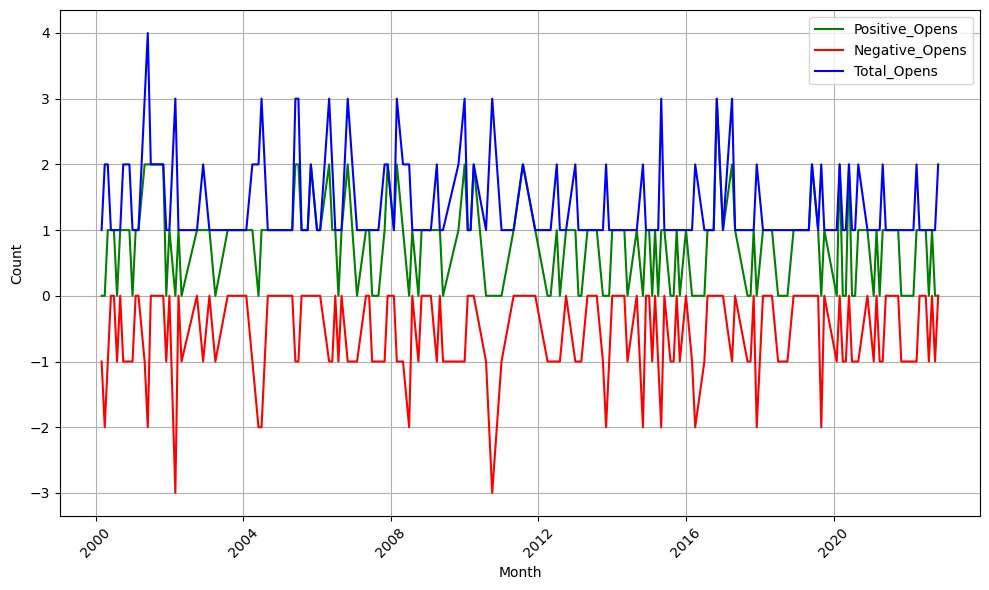

In [128]:
inspect_trade_results(trading_res)